In [3]:
!pip install kaggle tensorflow numpy pandas matplotlib scikit-learn split-folders

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elhamlolo","key":"b56e2dd61367e682bf5fca1b0a1ea222"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
#!unzip cifake-real-and-ai-generated-synthetic-images.zip -d dataset
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: datas

In [7]:
import os
import splitfolders
import random
import sys
import shutil
import logging
import cv2
import time
import requests
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import tensorflow        as tf
from   tensorflow.keras.models        import load_model
from   tensorflow.keras.applications  import VGG16, ResNet50, MobileNetV2,InceptionResNetV2, InceptionV3,DenseNet201, Xception, EfficientNetB0
from   tensorflow.keras.models        import Sequential, Model
from   tensorflow.keras.layers        import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from   tensorflow.keras.preprocessing import image
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   keras.callbacks                import EarlyStopping
from   sklearn.metrics                import accuracy_score, confusion_matrix,  precision_score, recall_score, classification_report, f1_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from   io                             import BytesIO
from   PIL                            import Image

In [8]:
print ("Python version is     : " , sys.version   )
print ("tensorflow version is : " , tf.__version__)

# Get detailed information about GPU(s)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("\nTensorFlow is using the following GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("\nNo GPU detected or TensorFlow is not configured to use one.")

#pip show tensorflow

Python version is     :  3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
tensorflow version is :  2.19.0

TensorFlow is using the following GPU(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [9]:
environment = 'colab'

if environment =='colab':
  inputFolder  = '/content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/'
  outputFolder = '/content/dataset/CT_split/'
  results_path  = '/content/dataset/Results/'

else:
  inputFolder  = 'E:\\____My2024 Work\\___Research_Points\\Now\\Kidney Classification\\dataset\\All\\CT_dataset\\'
  outputFolder = 'E:\\____My2024 Work\\___Research_Points\\Now\\Kidney Classification\\dataset\\All\\CT_split\\'
  results_path  = 'E:\\____My2024 Work\\___Research_Points\\Now\\Kidney Classification\\Codes\My_Codes\\Results\\'

if not os.path.exists(results_path):
    os.makedirs(results_path)


<>:11: SyntaxWarning: invalid escape sequence '\M'
<>:11: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipython-input-3042539508.py:11: SyntaxWarning: invalid escape sequence '\M'
  results_path  = 'E:\\____My2024 Work\\___Research_Points\\Now\\Kidney Classification\\Codes\My_Codes\\Results\\'


In [10]:
# Split dataset into Train (80%), Validation (10%), Test (10%)
splitfolders.ratio(inputFolder, outputFolder, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 12446 files [00:09, 1315.17 files/s]


In [11]:
train_dir    = outputFolder + 'train'
val_dir      = outputFolder + 'val'
test_dir     = outputFolder + 'test'

classes      = ['Cyst', 'Normal', 'Stone', 'Tumor']
random.seed(42)

IMAGE_WIDTH  = 224
IMAGE_HEIGHT = 224
num_classes  = 4
img_size     = (IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size   = 32

#Done: DenseNet201, MobileNetV2, EfficientNetB0, ResNet50

#models    = ['VGG16', 'VGG19', 'ResNet50', 'ResNet101', 'ResNet152', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetV2B0', 'EfficientNetB0', 'MobileNetV3Small', 'MobileNetV2' ,'InceptionResNetV2', 'InceptionV3', 'Xception']
models     = ['VGG16' , 'ResNet50' ,'MobileNetV2' ,'InceptionResNetV2','InceptionV3', 'DenseNet201', 'Xception','EfficientNetB0']
model_name = 'DenseNet201'
results_path= results_path + model_name+"/"
model_path =  results_path #+ '_20Epochs.h5'

if not os.path.exists(model_path):
    os.makedirs(model_path)


In [12]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(val_dir))
print("Test_dir Subfolders : ", os.listdir(test_dir))

Train_dir Subfolders:  ['Normal', 'Tumor', 'Cyst', 'Stone']
Valid_dir Subfolders:  ['Normal', 'Tumor', 'Cyst', 'Stone']
Test_dir Subfolders :  ['Normal', 'Tumor', 'Cyst', 'Stone']


In [13]:
image_train_gen =ImageDataGenerator(
                                    rescale           = 1./255,
                                    rotation_range    = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range= 0.1,
                                    horizontal_flip   = True,
                                    zoom_range        = 0.2
                                  )

image_valid_gen =ImageDataGenerator(
                                    rescale           = 1./255,
                                    rotation_range    = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range= 0.1,
                                    horizontal_flip   = True,
                                    zoom_range        = 0.2
                                  )

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_ds = image_train_gen.flow_from_directory(
                                                train_dir,
                                                target_size= img_size,
                                                batch_size = batch_size,
                                                class_mode = 'sparse',
                                              )

valid_ds = image_valid_gen.flow_from_directory(
                                                val_dir,
                                                target_size= img_size ,
                                                batch_size = batch_size,
                                                class_mode = 'sparse',
                                               )
test_ds = test_datagen.flow_from_directory(
                                            test_dir,
                                            target_size= img_size ,
                                            batch_size = batch_size,
                                            class_mode = 'sparse',
                                            shuffle=False
                                           )

Found 9955 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.


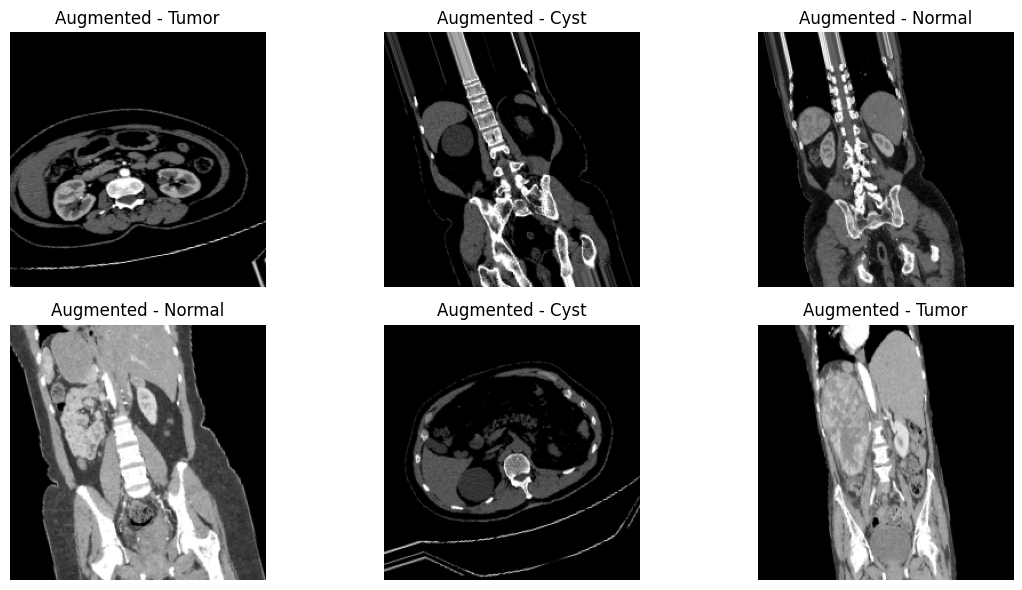

In [16]:
#show sample of augmented images
def show_augmented_images(dataset, num_images=6):

    images, labels = next(dataset)
    class_names    = list(dataset.class_indices.keys())

    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        img = images[i]
        label = class_names[int(labels[i])]

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Augmented - {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(results_path+ 'augmented_samples.png', dpi=300, bbox_inches='tight')

    plt.show()

show_augmented_images(train_ds, num_images=6)

In [19]:
model        = DenseNet201(input_shape=(IMAGE_WIDTH , IMAGE_HEIGHT ,3), weights='imagenet', include_top=False, pooling='avg')

for layer in model.layers:
      layer.trainable = False

x     = Flatten()(model.output)
x     = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = model.input, outputs = x)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [20]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#model.summary()

In [21]:
EarlyStoppingMonitor  = EarlyStopping(patience=10)
history               = model.fit(train_ds, epochs= 20, validation_data=valid_ds, callbacks= [EarlyStoppingMonitor])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 300s 810ms/step - accuracy: 0.6293 - loss: 0.9537 - val_accuracy: 0.8172 - val_loss: 0.5310
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 157s 504ms/step - accuracy: 0.8376 - loss: 0.4721 - val_accuracy: 0.8599 - val_loss: 0.4248
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 160s 511ms/step - accuracy: 0.8745 - loss: 0.3755 - val_accuracy: 0.8865 - val_loss: 0.3461
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 157s 503ms/step - accuracy: 0.8935 - loss: 0.3205 - val_accuracy: 0.8953 - val_loss: 0.3177
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 159s 510ms/step - accuracy: 0.9102 - loss: 0.2874 - val_accuracy: 0.8945 - val_loss: 0.2975
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 157s 502ms/step - accuracy: 0.9103 - loss: 0.2661 - val_accuracy: 0.8994 - val_loss: 0.2954
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 157s 503ms/step - accuracy: 0.9197 - loss: 0.2378 - val_accuracy: 0.9227 - val_loss: 0.2569
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 155s 498ms/step - accuracy: 0.9262 -

In [22]:
model.save(model_path + '_20Epochs.keras')

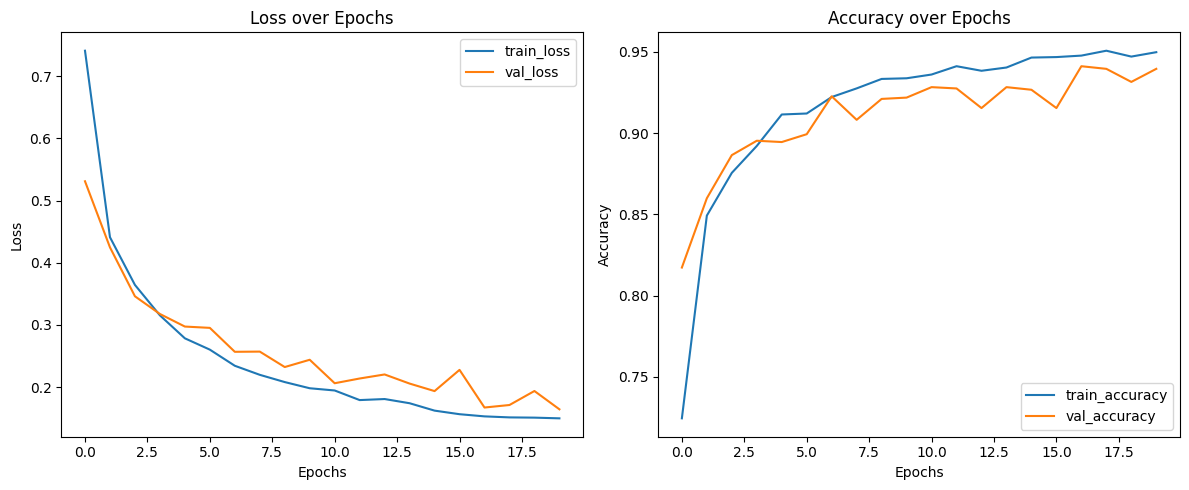

In [24]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss']    , label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy']    , label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')

plt.tight_layout()

# Save the figure
plt.savefig(results_path+ 'Loss_accuracy.png', dpi=300, bbox_inches='tight')

plt.show()

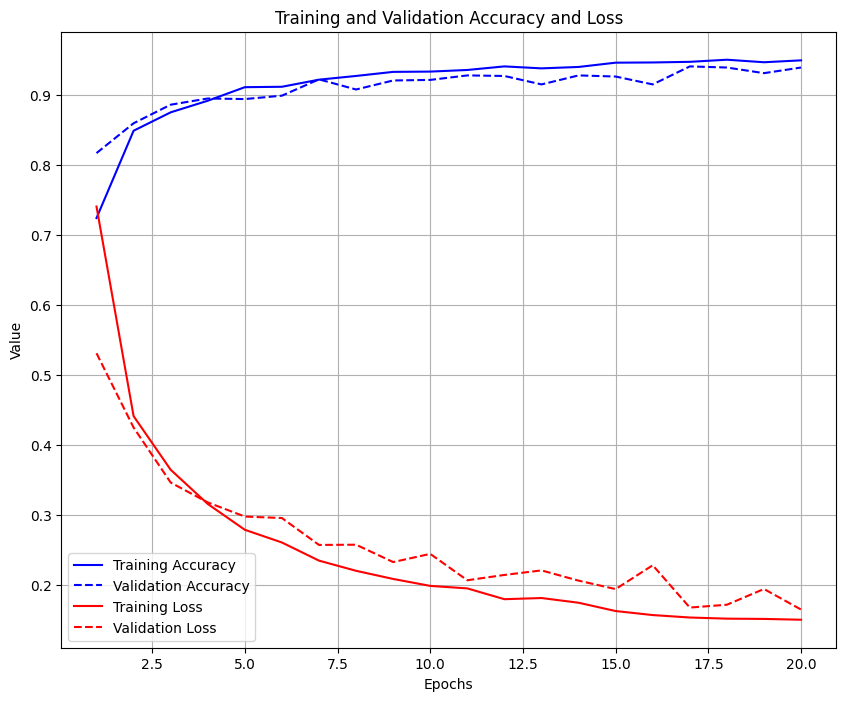

In [25]:
epochs  = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(10, 8))

# Plot accuracy
plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b--', label='Validation Accuracy')

# Plot loss
plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')

plt.title('Training and Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.savefig(results_path+ 'Loss_accuracy_oneFigure.png', dpi=300, bbox_inches='tight')

plt.show()

In [27]:
#1- Evaluate the model on the test data using `evaluate`
_, accuracy = model.evaluate(test_ds, batch_size=32)
print()
print('evaluation accuracy is :  %.3f' % (accuracy * 100.0))
print()

40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 614ms/step - accuracy: 0.9604 - loss: 0.1191

evaluation accuracy is :  94.315



40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 667ms/step


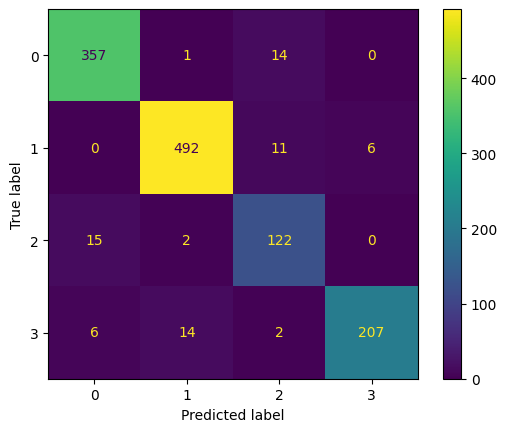

In [31]:
predictions            = model.predict(test_ds)
y_test                 = test_ds.classes

y_pred                 = np.argmax(predictions, axis=1)  # Get the index of the maximum value
cm                     = confusion_matrix(y_test, y_pred)

cmd                    = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(include_values= True, cmap='viridis', ax=None, xticks_rotation='horizontal')

# Save the figure
plt.savefig(results_path + 'Confusion Matrix.png', dpi=300, bbox_inches='tight')

plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       372
           1       0.97      0.97      0.97       509
           2       0.82      0.88      0.85       139
           3       0.97      0.90      0.94       229

    accuracy                           0.94      1249
   macro avg       0.93      0.93      0.93      1249
weighted avg       0.94      0.94      0.94      1249



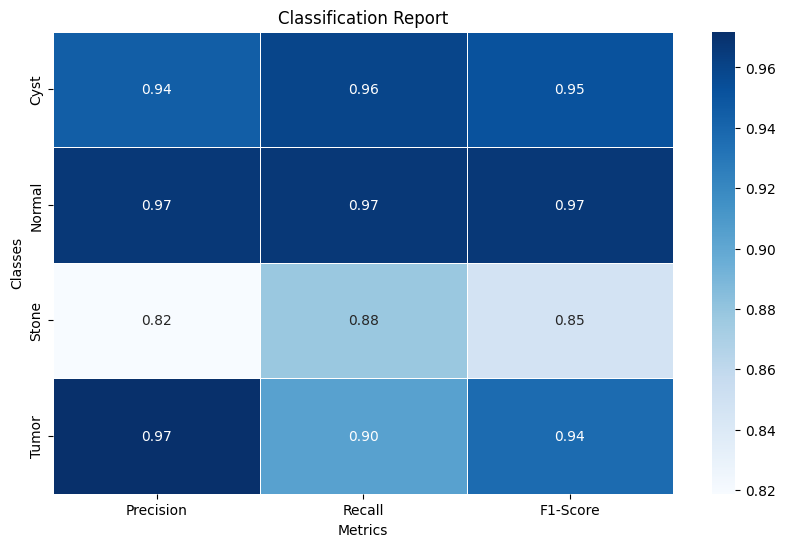

In [32]:
y_pred   = model.predict(test_ds)
y_test   = test_ds.classes

predicted_classes = [np.argmax(pred) for pred in predictions]

print(classification_report(y_test, predicted_classes))

report            = classification_report(y_test, predicted_classes, target_names=classes, output_dict=True)
metrics           = {label: report[label]        for label in classes if label in report}
precision_1       = [metrics[label]['precision'] for label in classes]
recall_1          = [metrics[label]['recall']    for label in classes]
f1_score_1        = [metrics[label]['f1-score']  for label in classes]

data = {
        'Precision': precision_1,
        'Recall'   : recall_1,
        'F1-Score' : f1_score_1
        }

df   = pd.DataFrame(data, index=classes)

plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')

# Save the figure
plt.savefig(results_path + 'Classification Report.png', dpi=300, bbox_inches='tight')

plt.show()

In [33]:
print ( ((precision_1[0]+ precision_1[1]+ precision_1[2]+ precision_1[3])/4)*100)
print ( ((recall_1[0]   + recall_1[1]   + recall_1[2]   + recall_1[3])/4)*100)
print ( ((f1_score_1[0] + f1_score_1[1] + f1_score_1[2] + f1_score_1[3])/4)*100)

92.54171388626469
92.69766427169374
92.56187461786386


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step


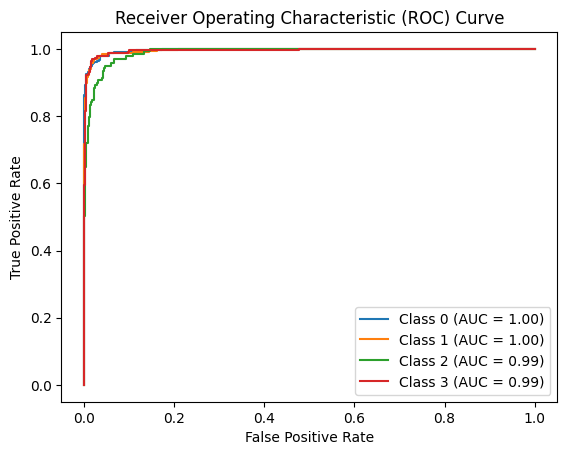

In [34]:
def plot_auc(predictions, y_test ):

    # Ensure that the target labels Y_test are in a 2-dimensional format
    if len(y_test.shape) == 1:
        y_test = np.eye(len(np.unique(y_test)))[y_test.astype(int)]

    # Compute the ROC curve and AUC score for each class
    fpr     = dict()
    tpr     = dict()
    roc_auc = dict()

    for i in range(y_test.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
        roc_auc[i]        = roc_auc_score(y_test[:, i], predictions[:, i])

    # Plot the ROC curve for each class
    plt.figure()
    for i in range(y_test.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Set the title and axis labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    # Save the figure
    plt.savefig(results_path + 'ROC.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

y_test = test_ds.classes
y_pred = model.predict(test_ds)
plot_auc(y_pred, y_test)


In [35]:
# Extract true label from image path
def extract_true_label(img_path):

    print (img_path)
    folder_name = os.path.basename(os.path.dirname(img_path))
    print (folder_name)

    if "Cyst" in folder_name:
        return "Cyst"
    elif "Normal" in folder_name:
        return "Normal"
    elif "Stone" in folder_name:
        return "Stone"
    elif "Tumor" in folder_name:
        return "Tumor"

    return "Unknown"

# Load and preprocess image
def load_and_preprocess_image(img_path, target_size):

    if img_path.startswith('http'):
        response = requests.get(img_path)
        img      = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        img      = image.load_img(img_path)

    # Resize image explicitly
    img          = img.resize(target_size)

    # Convert to array and normalize
    img_array    = image.img_to_array(img) / 255.0
    img_array    = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

/content/dataset/CT_split/test/Cyst/Cyst- (100).jpg
Cyst
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


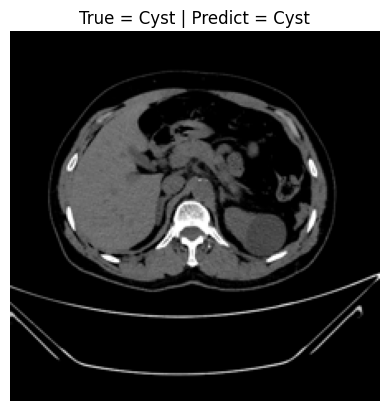

True = Cyst    Predict = Cyst


In [36]:
# Image path (URL or local)
img_path = test_dir + '/Cyst/Cyst- (100).jpg'#Cyst- (4).jpg

# Extract true label
true_label     = extract_true_label(img_path)

# Load and preprocess image
img, img_array = load_and_preprocess_image(img_path, img_size)

# Make prediction
pred       = model.predict(img_array)
pred_index = np.argmax(pred,axis=1)

if pred_index[0]   == 0:
  predicted_label = "Cyst"

elif pred_index[0] == 1:
  predicted_label = "Normal"

elif pred_index[0] == 2:
  predicted_label = "Stone"

elif pred_index[0] == 3:
  predicted_label = "Tumor"

# Display image
plt.imshow(img)
plt.axis('off')
plt.title(f"True = {true_label} | Predict = {predicted_label}")
plt.show()

# Print result
print(f"True = {true_label}    Predict = {predicted_label}")